In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

import healpy as hp

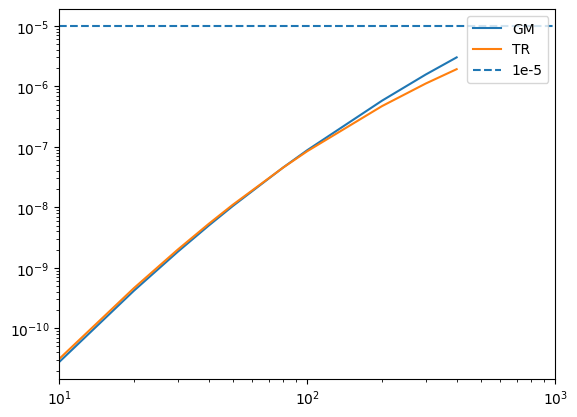

In [141]:
lmaxes_th = [10, 20, 30, 40, 50, 80, 100, 200, 300, 400]#, 600, 800]#, 1000, 1100, 2000]

dirnew = "allowed_configs_results"
dirthree = "allowed_configs_results_threej"

GM, TR = "GM", "TR"
cases = [GM, TR]

results = {}

direcs = [dirthree]

for case in cases:
    def read(direc, lmax):
        with open(f"{direc}/{case}_allowed_configs_{lmax}", "rb") as fp:
            results = pickle.load(fp)
        return np.array(results)

    getsum = lambda direc, l: np.sum(read(direc, l))/4/np.pi

    calculations = [np.array(list(map(lambda l: getsum(d_, l), lmaxes_th))) for d_ in direcs]
    results[case] = calculations


    [plt.loglog(lmaxes_th, calculation, label = case) for calculation, d_ in zip(calculations, direcs)]
plt.hlines(1e-5, 10, 1000, linestyles = "dashed", label = "1e-5")
plt.xlim(10, 1000)
plt.legend()

In [3]:
input_map = "/Users/omard/Downloads/SCRATCHFOLDER/giuliosims/map0_kappa_ecp262_dmn2_lmax8000_first.fits"
mappa = hp.read_map(input_map)

In [29]:
#mappa_alm = hp.map2alm(mappa, lmax = 4000)

In [76]:
mappa_alm = hp.read_alm("mappa_alm_lmax_4000.fits")

In [61]:
def arcmin2rad(arcmin):
    return arcmin/60*np.pi/180

In [62]:
mappa_alm_smoothed = hp.sphtfunc.smoothalm(mappa_alm, fwhm = arcmin2rad(10), pol = False)

In [28]:
#hp.write_alm("mappa_alm_lmax_4000.fits", mappa_alm, overwrite = True)

In [99]:
def filter_alms(alms, lmax):
    Lmax = hp.Alm.getlmax(len(alms))
    ells = np.arange(Lmax+1)
    lowpass = np.zeros_like(ells, dtype = np.float64)
    lowpass[ells <= lmax] = 1.
    return hp.almxfl(alms, lowpass)

def change_lmax_mappa(alms, lmax, nside = 4096):
    new = filter_alms(alms, lmax)
    nside = 1024#(lmax+1)//3
    return hp.alm2map(new, nside = nside, pol = False)

def get_skew_from_map(mappa):
    return np.mean((mappa-np.mean(mappa))**3)


def get_skew_from_lmax(alms, lmax, nside = 4096):
    return get_skew_from_map(change_lmax_mappa(alms, lmax, nside = nside))


lmaxes = [10, 20, 30, 40, 50, 80, 100, 200, 300, 400, 600, 800, 1000, 1100, 2000]
skews = np.array(list(map(lambda l: get_skew_from_lmax(mappa_alm, l), lmaxes)))


In [173]:
lmaxes_th_3 = [10, 20, 30, 40, 50, 80, 100, 200, 300, 400, 600, 800, 1000]#, 600, 800, 1000]#, 1100, 2000]
dirthree = "allowed_configs_results_threej"
dirnew = "allowed_configs_results"
def read(direc, lmax):
    with open(f"{direc}/GM_allowed_configs_{lmax}", "rb") as fp:
        results = pickle.load(fp)
    return np.array(results)

getsum = lambda direc, l: np.sum(read(dirnew, l))/4/np.pi

calcthree = [np.array(list(map(lambda l: getsum(d_, l), lmaxes_th_3))) for d_ in direcs]

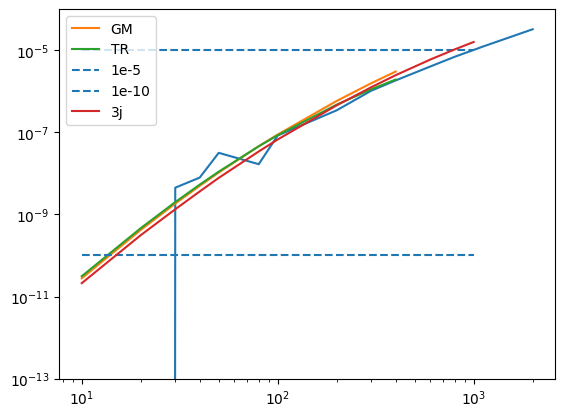

In [175]:
plt.plot(lmaxes, (skews))
for k, calculations in results.items():
    [plt.loglog(lmaxes_th, calculation, label = k) for calculation, d_ in zip(calculations, direcs)]
plt.hlines(1e-5, 10, 1000, linestyles = "dashed", label = "1e-5")
plt.hlines(1e-10, 10, 1000, linestyles = "dashed", label = "1e-10")
plt.plot(lmaxes_th_3, calcthree[0], label = "3j")
plt.ylim(1e-13, 1e-4)
plt.legend()


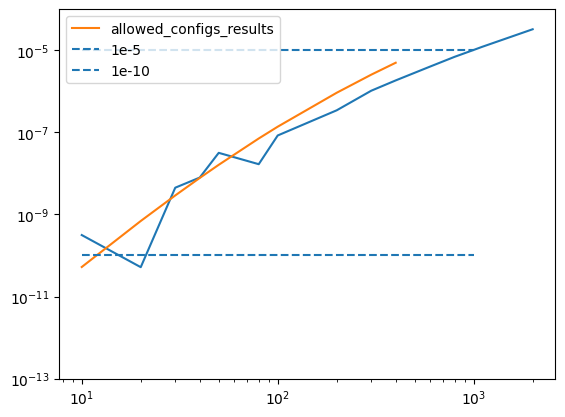

In [102]:
plt.plot(lmaxes, abs(skews))
[plt.loglog(lmaxes_th, calculation, label = d_) for calculation, d_ in zip(calculations, direcs)]
plt.hlines(1e-5, 10, 1000, linestyles = "dashed", label = "1e-5")
plt.hlines(1e-10, 10, 1000, linestyles = "dashed", label = "1e-10")

plt.ylim(1e-13, 1e-4)
plt.legend()


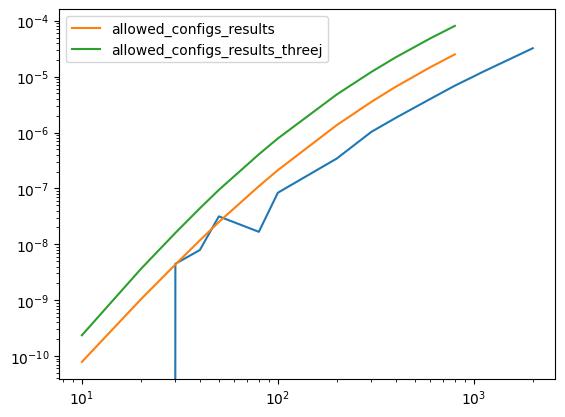

In [50]:
plt.plot(lmaxes, skews)
[plt.loglog(lmaxes_th, calculation, label = d_) for calculation, d_ in zip(calculations, direcs)]
plt.legend()
